# Импорт библиотек

In [1]:
# based on https://www.kaggle.com/konstanter/fasterrcnn-pytorch-maskdetection

from torchmetrics.detection import MeanAveragePrecision
import numpy as np 
import pandas as pd 
import torchvision
import random
from torchvision import transforms, datasets, models
import torch
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
import cv2
import os
from time import time
import xml.etree.ElementTree as et
import glob
import shutil
from tqdm import tqdm
from collections import defaultdict

# Faster RCNN


### Загрузим данные в DataLoader

In [2]:
# путь к файлам
images_dir = './images/'
annotations_dir = './annotations/'


class FaceMaskDataset(torch.utils.data.Dataset):

    def __init__(self, images_dir, annotation_dir,width, height, transforms=None):
        self.transforms = transforms
        self.images_dir = os.path.abspath(images_dir)
        self.annotation_dir = os.path.abspath(annotation_dir)
        self.height = height
        self.width = width
        
        # сортировка изображений
        self.imgs = [image for image in sorted(os.listdir(images_dir))]
        self.annotate = [image for image in sorted(os.listdir(annotation_dir))]
        
        # на 0й позиции находится фон
        self.classes = ['__background__', 'without_mask','with_mask','mask_weared_incorrect']

    def __getitem__(self, idx):

        img_name = self.imgs[idx]
        image_path = os.path.join(self.images_dir, img_name)

        # изменение цвета и размера изображения    
        img = cv2.imread(image_path)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)
        img_res = cv2.resize(img_rgb, (self.width, self.height), cv2.INTER_AREA)
        # нормализация изображения
        img_res /= 255.0
        
        # аннотация
        annot_filename = self.annotate[idx]
        annot_file_path = os.path.join(self.annotation_dir, annot_filename)
        
        boxes = []
        labels = []
        tree = et.parse(annot_file_path)
        root = tree.getroot()
        
        # высота и ширина изобрадения
        wt = img.shape[1]
        ht = img.shape[0]
        
        # ограничивающие рамки
        for member in root.findall('object'):
            labels.append(self.classes.index(member.find('name').text))
            
            # bounding box
            xmin = int(member.find('bndbox').find('xmin').text)
            xmax = int(member.find('bndbox').find('xmax').text)
            
            ymin = int(member.find('bndbox').find('ymin').text)
            ymax = int(member.find('bndbox').find('ymax').text)
            
            xmin_corr = xmin/wt
            xmax_corr = xmax/wt
            ymin_corr = ymin/ht
            ymax_corr = ymax/ht
            
            xmin_corr = max(0.0, min(xmin_corr, 1.0)) * self.width
            xmax_corr = max(0.0, min(xmax_corr, 1.0)) * self.width
            ymin_corr = max(0.0, min(ymin_corr, 1.0)) * self.height
            ymax_corr = max(0.0, min(ymax_corr, 1.0)) * self.height
            
            boxes.append([xmin_corr, ymin_corr, xmax_corr, ymax_corr])
        
        if len(boxes) == 0:
            # Add a dummy box covering 5% of the image in the corner
            print(f"Warning: No valid boxes in {annot_file_path}, adding dummy box")
            boxes.append([0.0, 0.0, 0.05, 0.05])  # Normalized coordinates
            labels.append(1)  # 'without_mask' class (not background!)
            
        if len(boxes) != len(labels):
            print(f"ERROR: Mismatch between boxes ({len(boxes)}) and labels ({len(labels)})", annot_file_path)
        
        # перевод boxes в формат torch.Tensor
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])

        iscrowd = torch.zeros((boxes.shape[0],), dtype=torch.int64)
        
        labels = torch.as_tensor(labels, dtype=torch.int64)


        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["area"] = area
        target["iscrowd"] = iscrowd

        image_id = torch.tensor([idx])
        target["image_id"] = image_id


        if self.transforms:
            
            sample = self.transforms(image = img_res,
                                     bboxes = target['boxes'],
                                     labels = labels)
            
            img_res = sample['image']
            target['boxes'] = torch.Tensor(sample['bboxes'])
            
            
            
        return img_res, target

    def __len__(self):
        return len(self.imgs)


# проверка датасета
dataset = FaceMaskDataset(images_dir, annotations_dir, 224, 224)
print('length of dataset = ', len(dataset), '\n')

img, target = dataset[78]
print('Image shape = ', img.shape, '\n','Target - ', target)

length of dataset =  853 

Image shape =  (224, 224, 3) 
 Target -  {'boxes': tensor([[113.1163, 146.7200, 163.7209, 205.5200]]), 'labels': tensor([2]), 'area': tensor([2975.5537]), 'iscrowd': tensor([0]), 'image_id': tensor([78])}


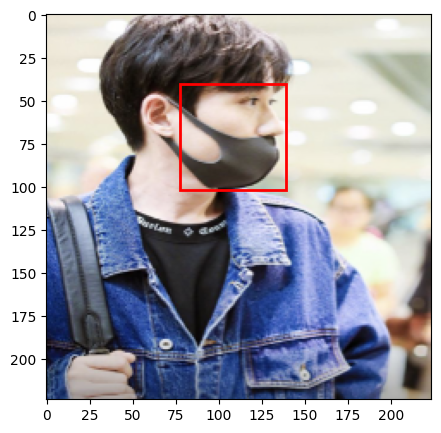

In [3]:
# Вспомогательная функция для визуализации bbox

def plot_img_bbox(img, target):
    fig, a = plt.subplots(1,1)
    fig.set_size_inches(5,5)
    a.imshow(img)
    for box in (target['boxes']):
        x, y, width, height  = box[0], box[1], box[2]-box[0], box[3]-box[1]
        rect = patches.Rectangle((x, y),
                                 width, height,
                                 linewidth = 2,
                                 edgecolor = 'r',
                                 facecolor = 'none')

        # Отрисуем bbox поверх картинки
        a.add_patch(rect)
    plt.show()
    
img, target = dataset[38]
plot_img_bbox(img, target)

In [4]:
def get_transform(train):
    if train:
        return A.Compose([
            A.HorizontalFlip(0.5),
            A.VerticalFlip(p=0.2),
            A.RandomBrightnessContrast(p=0.2),
            A.ShiftScaleRotate(shift_limit=0.2, scale_limit=0.2, rotate_limit=30, p=0.5),
            ToTensorV2(p=1.0),
        ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels'], 'min_visibility': 0.3})
    else:
        return A.Compose([
            ToTensorV2(p=1.0)
        ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

In [5]:
def collate_fn(batch):
    return tuple(zip(*batch))

### Разделим выборки на тренировочную и валидационную

In [6]:
dataset = FaceMaskDataset(images_dir, annotations_dir, 480, 480, transforms=get_transform(train=True))
dataset_test = FaceMaskDataset(images_dir, annotations_dir, 480, 480, transforms=get_transform(train=False))

# разделим данные на train и test
torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()

test_split = 0.2
tsize = int(len(dataset)*test_split)
dataset = torch.utils.data.Subset(dataset, indices[:-tsize])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-tsize:])

data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=10, shuffle=True,
    collate_fn=collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=10, shuffle=False,
    collate_fn=collate_fn)

In [7]:
def get_model_instance_segmentation(num_classes):
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
   
    in_features = model.roi_heads.box_predictor.cls_score.in_features

    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model

# Обучение модели

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

num_classes = 4

model = get_model_instance_segmentation(num_classes)

num_epochs = 5

model.to(device)

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                                momentum=0.9, weight_decay=0.0005)

lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

len_dataloader = len(data_loader)

for epoch in range(num_epochs):
    print(f'Epoch :{epoch + 1}')
    start_time = time()
    model.train()
    i = 0    
    epoch_loss = 0
    for imgs, annotations in data_loader:
        try:
            i += 1
            imgs = list(img.to(device) for img in imgs)
            annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
            loss_dict = model(imgs, annotations)
            losses = sum(loss for loss in loss_dict.values())        

            optimizer.zero_grad()
            losses.backward()
            optimizer.step()         
            epoch_loss += losses.item()
        except Exception as e:
            print(imgs, annotations, e)
        
    time_elapsed = time() - start_time
    print('{:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Epoch_loss = ',epoch_loss)


/Users/alex/skillset/Python/Test/sf_ds_projects/cv_project_2/venv/lib/python3.13/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/alex/skillset/Python/Test/sf_ds_projects/cv_project_2/venv/lib/python3.13/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch :1


libpng warning: iCCP: Not recognizing known sRGB profile that has been edited


[tensor([[[0.8135, 0.7798, 0.7522,  ..., 0.1139, 0.1081, 0.0926],
         [0.8132, 0.7769, 0.7576,  ..., 0.1135, 0.1060, 0.0886],
         [0.8027, 0.7754, 0.7607,  ..., 0.1134, 0.1048, 0.0860],
         ...,
         [0.6014, 0.6140, 0.6281,  ..., 0.0820, 0.0834, 0.1025],
         [0.6074, 0.6245, 0.6318,  ..., 0.0808, 0.0899, 0.0980],
         [0.6145, 0.6238, 0.6292,  ..., 0.0829, 0.0953, 0.0939]],

        [[0.8224, 0.8022, 0.7844,  ..., 0.1217, 0.1159, 0.1037],
         [0.8233, 0.8019, 0.7887,  ..., 0.1200, 0.1119, 0.0983],
         [0.8181, 0.8020, 0.7909,  ..., 0.1186, 0.1096, 0.0946],
         ...,
         [0.5241, 0.5328, 0.5528,  ..., 0.1578, 0.1607, 0.1796],
         [0.5252, 0.5405, 0.5534,  ..., 0.1541, 0.1649, 0.1707],
         [0.5320, 0.5412, 0.5501,  ..., 0.1538, 0.1671, 0.1616]],

        [[0.8055, 0.7973, 0.7875,  ..., 0.0771, 0.0762, 0.0731],
         [0.8122, 0.8022, 0.7940,  ..., 0.0767, 0.0727, 0.0687],
         [0.8118, 0.8064, 0.7982,  ..., 0.0769, 0.0708, 0

libpng warning: iCCP: Not recognizing known sRGB profile that has been edited


[tensor([[[0.6000, 0.5909, 0.5742,  ..., 0.8909, 0.8093, 0.6928],
         [0.6311, 0.6214, 0.5892,  ..., 0.8658, 0.7601, 0.6555],
         [0.6511, 0.6427, 0.6055,  ..., 0.8136, 0.7115, 0.6456],
         ...,
         [0.5211, 0.5399, 0.5285,  ..., 0.0000, 0.0000, 0.0000],
         [0.5632, 0.5494, 0.5003,  ..., 0.0000, 0.0000, 0.0000],
         [0.5560, 0.5091, 0.4315,  ..., 0.0000, 0.0000, 0.0000]],

        [[0.3876, 0.3721, 0.3352,  ..., 0.3859, 0.3105, 0.1886],
         [0.4813, 0.4608, 0.3893,  ..., 0.3709, 0.2688, 0.1590],
         [0.5567, 0.5371, 0.4450,  ..., 0.3181, 0.2161, 0.1467],
         ...,
         [0.5096, 0.5269, 0.5182,  ..., 0.0000, 0.0000, 0.0000],
         [0.5535, 0.5374, 0.4898,  ..., 0.0000, 0.0000, 0.0000],
         [0.5490, 0.4983, 0.4211,  ..., 0.0000, 0.0000, 0.0000]],

        [[0.4112, 0.3982, 0.3697,  ..., 0.4375, 0.3405, 0.1789],
         [0.4976, 0.4808, 0.4201,  ..., 0.4168, 0.2867, 0.1404],
         [0.5660, 0.5509, 0.4702,  ..., 0.3470, 0.2178, 0

libpng warning: iCCP: Not recognizing known sRGB profile that has been edited


[tensor([[[0.6927, 0.6593, 0.6082,  ..., 0.2829, 0.2698, 0.2544],
         [0.6836, 0.6457, 0.6019,  ..., 0.2828, 0.2664, 0.2544],
         [0.6726, 0.6296, 0.5943,  ..., 0.2827, 0.2624, 0.2551],
         ...,
         [0.5552, 0.5470, 0.5456,  ..., 0.9432, 0.9344, 0.9495],
         [0.5672, 0.5537, 0.5481,  ..., 0.9423, 0.9384, 0.9552],
         [0.5763, 0.5583, 0.5503,  ..., 0.9418, 0.9418, 0.9598]],

        [[0.7098, 0.6764, 0.6253,  ..., 0.3083, 0.2955, 0.2749],
         [0.7007, 0.6628, 0.6190,  ..., 0.3082, 0.2928, 0.2780],
         [0.6897, 0.6467, 0.6114,  ..., 0.3080, 0.2896, 0.2822],
         ...,
         [0.3229, 0.3169, 0.3159,  ..., 0.8282, 0.8260, 0.8438],
         [0.3229, 0.3149, 0.3122,  ..., 0.8240, 0.8268, 0.8491],
         [0.3229, 0.3126, 0.3092,  ..., 0.8214, 0.8279, 0.8536]],

        [[0.7475, 0.7192, 0.6738,  ..., 0.3651, 0.3494, 0.3263],
         [0.7384, 0.7056, 0.6676,  ..., 0.3643, 0.3453, 0.3278],
         [0.7274, 0.6896, 0.6599,  ..., 0.3635, 0.3403, 0

libpng warning: iCCP: Not recognizing known sRGB profile that has been edited


[tensor([[[0.6980, 0.6980, 0.6980,  ..., 0.4184, 0.5004, 0.5529],
         [0.7010, 0.7010, 0.7010,  ..., 0.4215, 0.5052, 0.5588],
         [0.6974, 0.6974, 0.6974,  ..., 0.4248, 0.5091, 0.5631],
         ...,
         [0.8507, 0.8526, 0.8556,  ..., 0.7149, 0.7463, 0.7663],
         [0.8853, 0.8806, 0.8731,  ..., 0.7718, 0.7143, 0.6775],
         [0.8588, 0.8442, 0.8214,  ..., 0.8529, 0.7800, 0.7333]],

        [[0.7020, 0.7020, 0.7020,  ..., 0.4223, 0.5044, 0.5569],
         [0.7049, 0.7049, 0.7049,  ..., 0.4252, 0.5073, 0.5598],
         [0.7013, 0.7013, 0.7013,  ..., 0.4285, 0.5106, 0.5631],
         ...,
         [0.8507, 0.8526, 0.8556,  ..., 0.7149, 0.7463, 0.7663],
         [0.8853, 0.8806, 0.8731,  ..., 0.7718, 0.7143, 0.6775],
         [0.8588, 0.8442, 0.8214,  ..., 0.8529, 0.7800, 0.7333]],

        [[0.7176, 0.7176, 0.7176,  ..., 0.4376, 0.5151, 0.5647],
         [0.7235, 0.7235, 0.7235,  ..., 0.4406, 0.5181, 0.5676],
         [0.7186, 0.7195, 0.7208,  ..., 0.4417, 0.5205, 0

libpng warning: iCCP: Not recognizing known sRGB profile that has been edited


9m 36s
Epoch_loss =  22.254702866077423
Epoch :6


libpng warning: iCCP: Not recognizing known sRGB profile that has been edited


9m 37s
Epoch_loss =  21.487548977136612
Epoch :7


libpng warning: iCCP: Not recognizing known sRGB profile that has been edited


9m 48s
Epoch_loss =  20.630464419722557
Epoch :8


libpng warning: iCCP: Not recognizing known sRGB profile that has been edited


9m 42s
Epoch_loss =  20.89767114818096


In [44]:
# вспомогательная функция принимает исходный прогноз и порог iou

def apply_nms(orig_prediction, iou_thresh=0.3):
    
    keep = torchvision.ops.nms(orig_prediction['boxes'], orig_prediction['scores'], iou_thresh)
    
    final_prediction = orig_prediction
    final_prediction['boxes'] = final_prediction['boxes'][keep]
    final_prediction['scores'] = final_prediction['scores'][keep]
    final_prediction['labels'] = final_prediction['labels'][keep]
    
    return final_prediction

def torch_to_pil(img):
    return transforms.ToPILImage()(img).convert('RGB')

In [45]:
img, target = dataset_test[4]

model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])[0]
    
print('predicted #boxes: ', len(prediction['labels']))
print('real #boxes: ', len(target['labels']))

predicted #boxes:  3
real #boxes:  1


EXPECTED OUTPUT


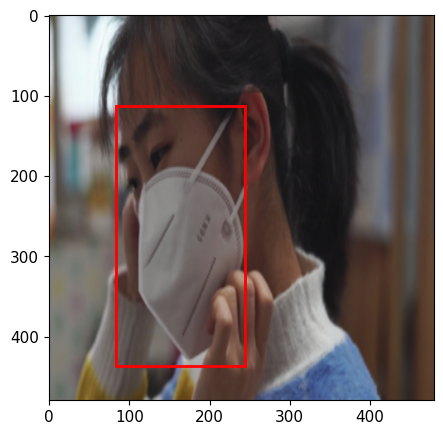

In [46]:
print('EXPECTED OUTPUT')
plot_img_bbox(torch_to_pil(img), target)

MODEL OUTPUT


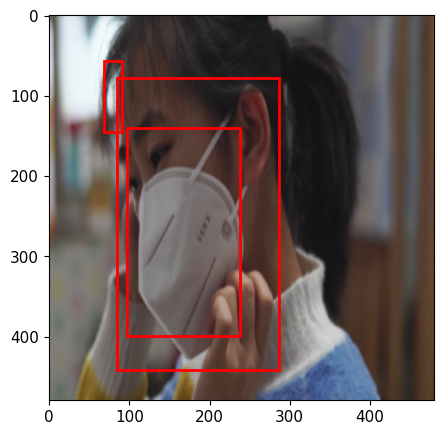

In [47]:
print('MODEL OUTPUT')
plot_img_bbox(torch_to_pil(img), prediction)

NMS APPLIED MODEL OUTPUT


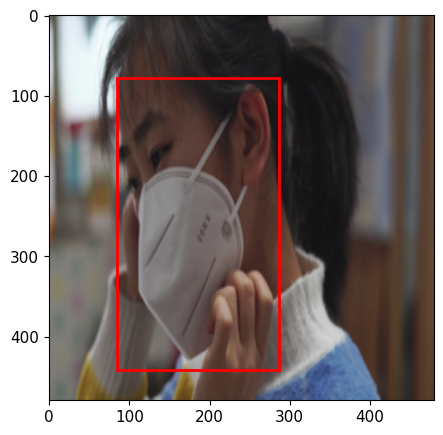

In [51]:
nms_prediction = apply_nms(prediction, iou_thresh=0.2)
print('NMS APPLIED MODEL OUTPUT')
plot_img_bbox(torch_to_pil(img), nms_prediction)

# Отрисовка изображений

In [52]:
def plot_image(img_tensor, annotation,predict=True):
    
    fig,ax = plt.subplots(1)
    fig.set_size_inches(18.5, 10.5)
    img = img_tensor.cpu().detach()
    mask_dic = {1:'without_mask', 2:'with_mask', 3:'mask_weared_incorrect'}

    ax.imshow(img.permute(1, 2, 0))
    
    for i,box in enumerate(annotation["boxes"]):
        xmin, ymin, xmax, ymax = box.detach().cpu().numpy()

        rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='r',facecolor='none')

        ax.add_patch(rect)
        label_idx = int(annotation['labels'][i].detach().cpu())
        label = mask_dic[label_idx]
        if predict:
            score = int((annotation['scores'][i].detach().cpu()) * 100)
            ax.text(xmin, ymin, f"{label} : {score}%", horizontalalignment='center', verticalalignment='center',fontsize=20,color='b')
        else:
            score=''
            ax.text(xmin, ymin, f"{label}", horizontalalignment='center', verticalalignment='center',fontsize=20,color='b')
    plt.show()

In [53]:
for imgs, annotations in data_loader:
        imgs = list(img.to(device) for img in imgs)
        annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
        break

In [54]:
model.eval()
preds = model(imgs)

Prediction


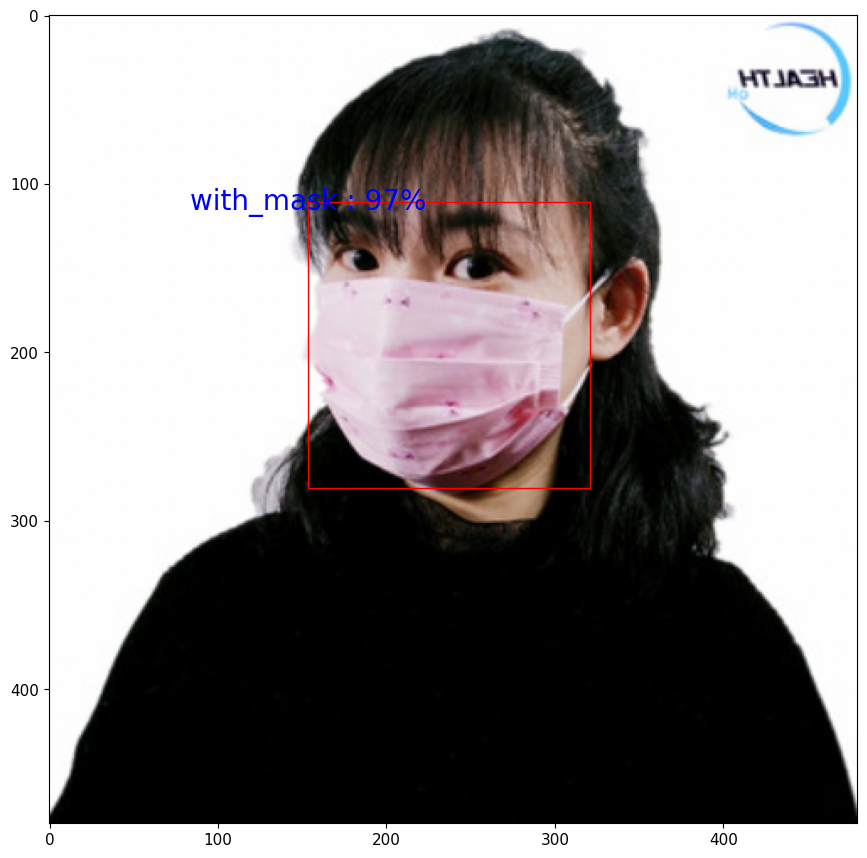

Target


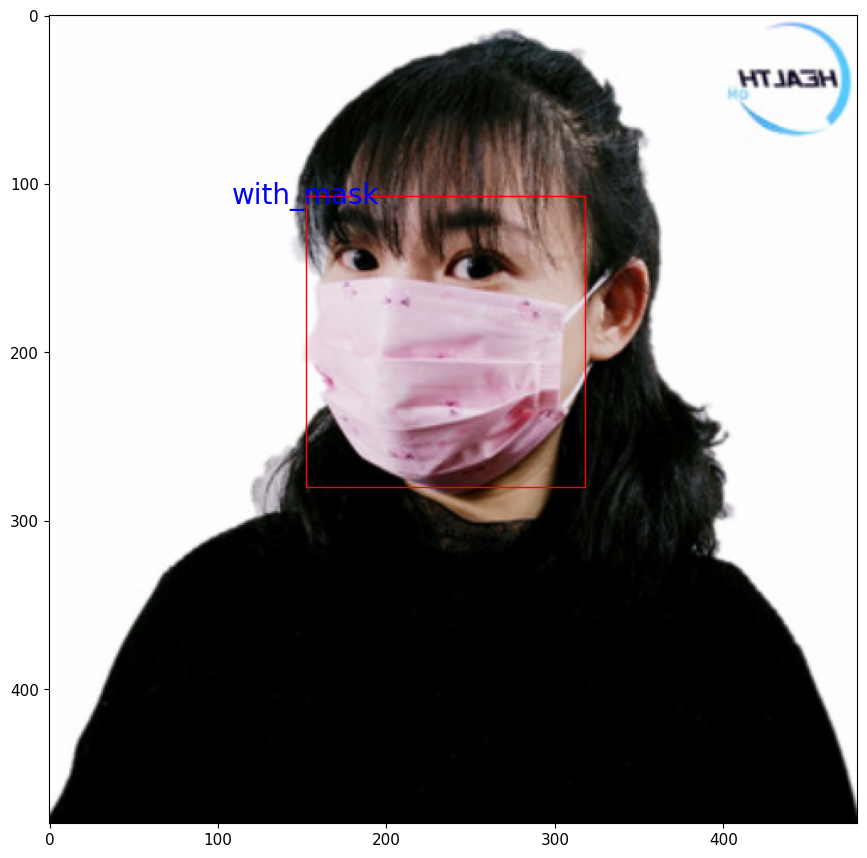

In [55]:
nms_prediction = apply_nms(preds[4], iou_thresh=0.2)
print("Prediction")
plot_image(imgs[4], nms_prediction)
print("Target")
plot_image(imgs[4].to('cpu'), annotations[4],False)

Prediction


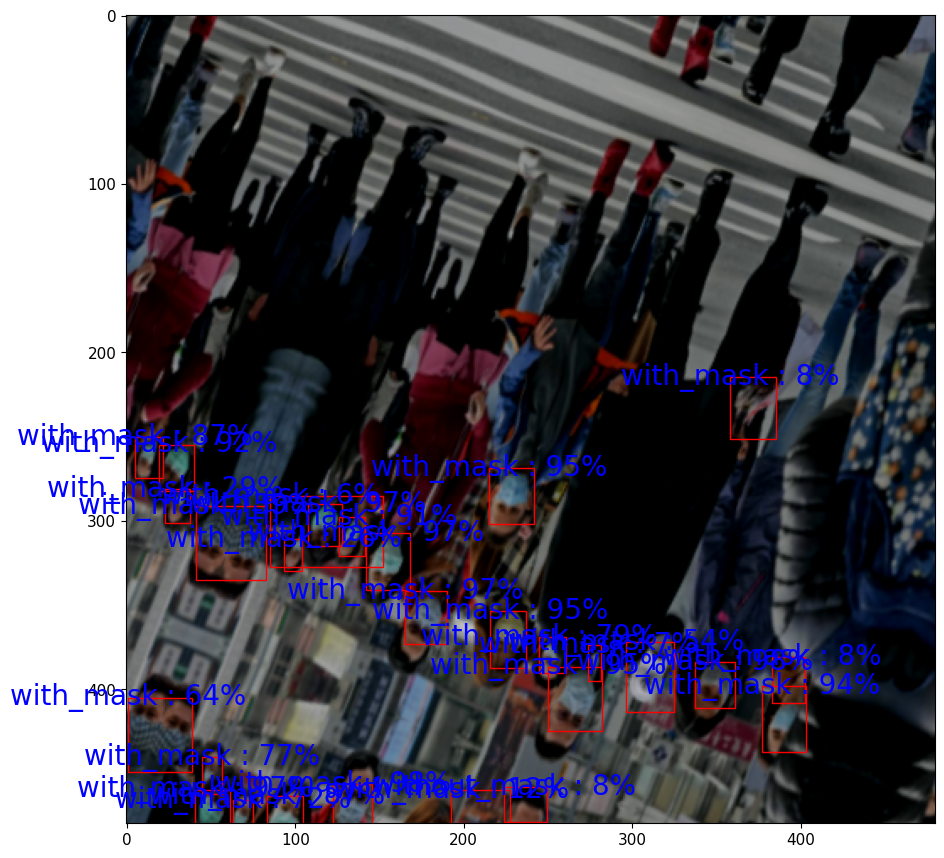

Target


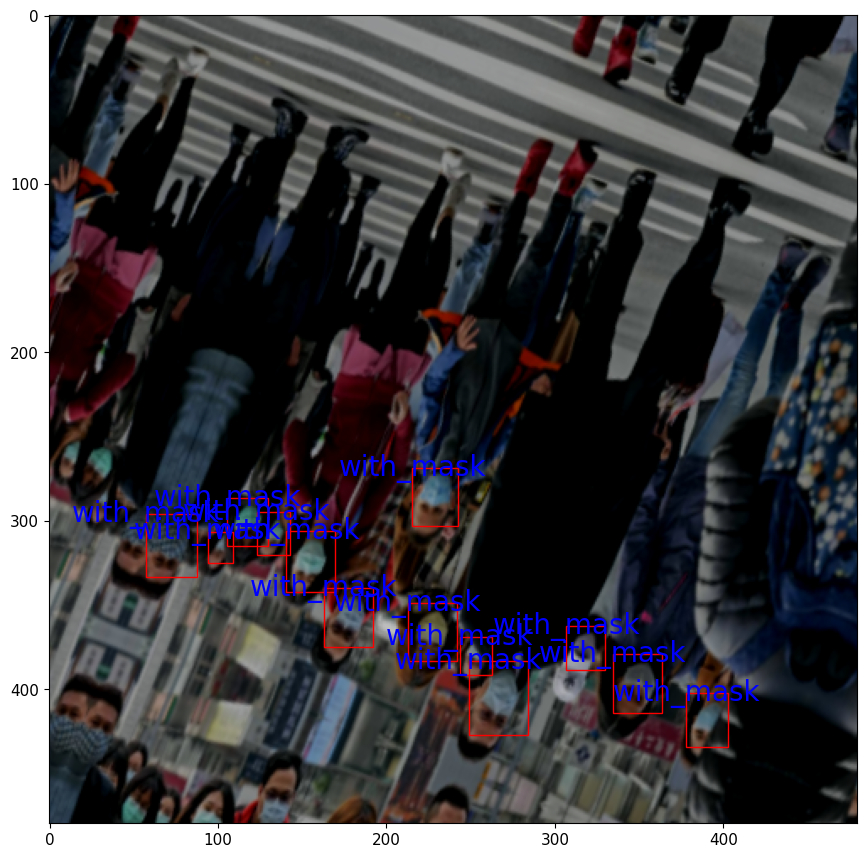

In [56]:
nms_prediction = apply_nms(preds[7], iou_thresh=0.2)
print("Prediction")
plot_image(imgs[7], nms_prediction)
print("Target")
plot_image(imgs[7].to('cpu'), annotations[7],False)

Prediction


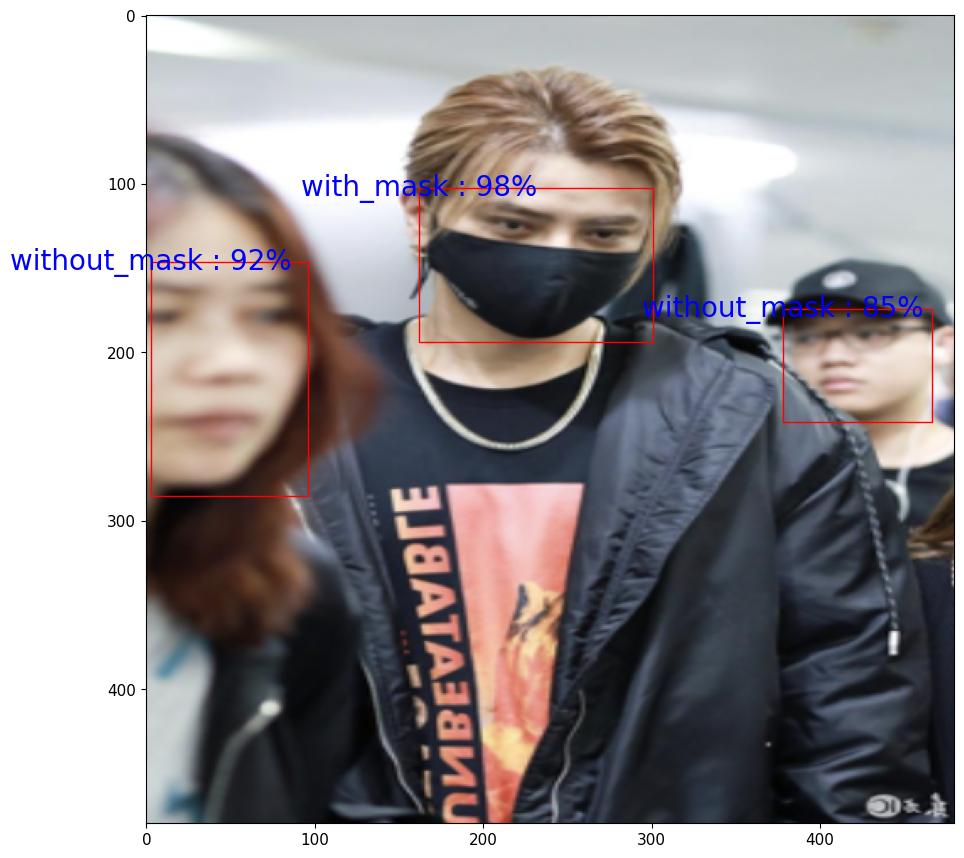

Target


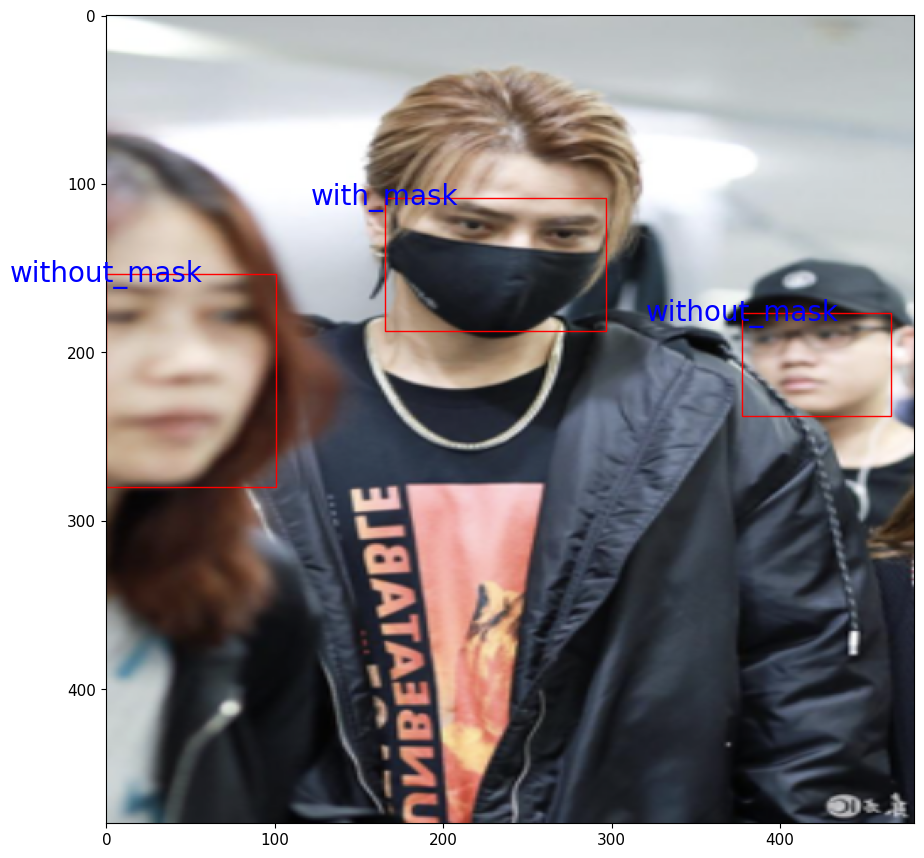

In [63]:
nms_prediction = apply_nms(preds[1], iou_thresh=0.01)
print("Prediction")
plot_image(imgs[1], nms_prediction)
print("Target")
plot_image(imgs[1].to('cpu'), annotations[1],False)

Prediction


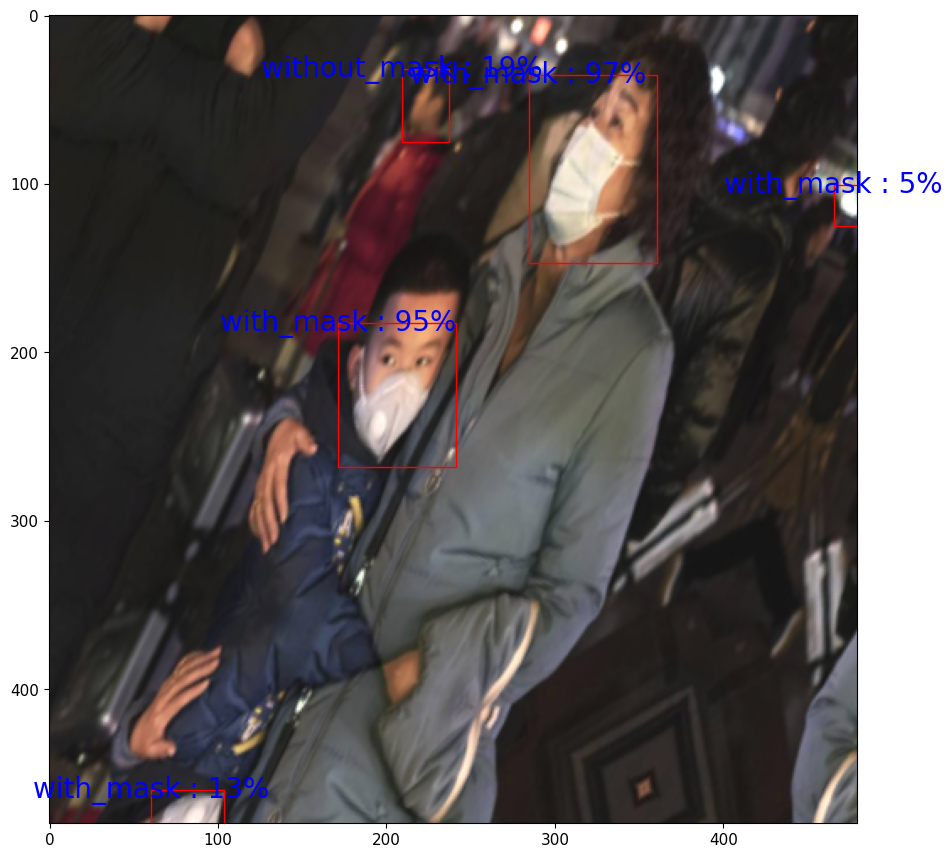

Target


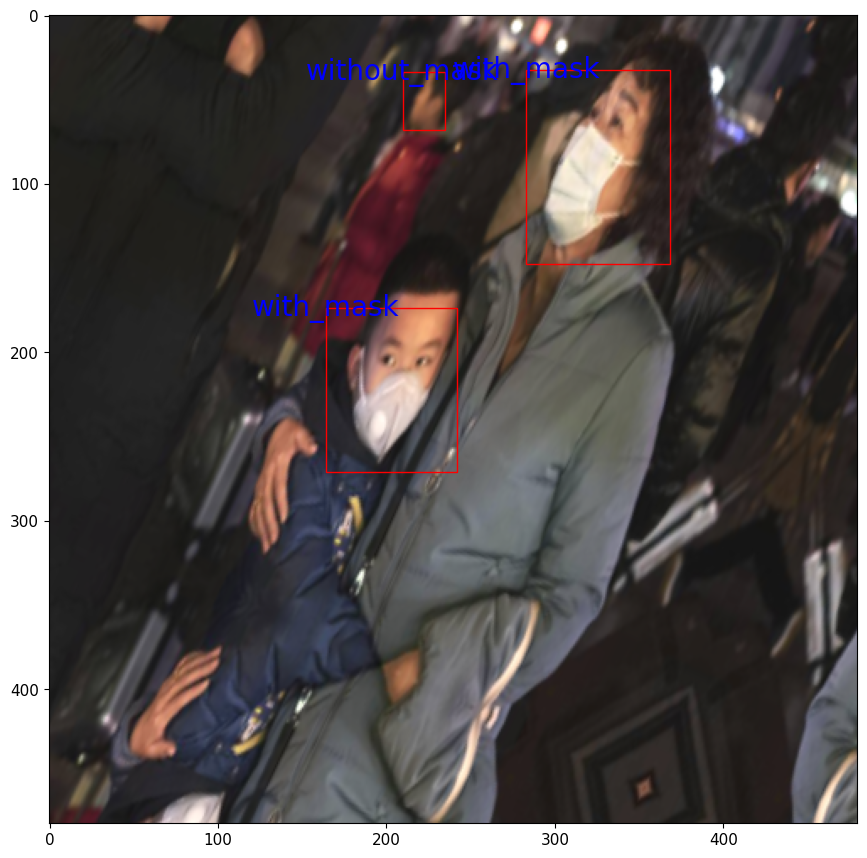

In [69]:
nms_prediction = apply_nms(preds[5], iou_thresh=0.1)
print("Prediction")
plot_image(imgs[5], nms_prediction)
print("Target")
plot_image(imgs[5].to('cpu'), annotations[5],False)

# Вычисление mAP на валидационной выборке

In [ ]:
map_metric = MeanAveragePrecision()

model.eval()
all_predictions = []
all_targets = []

with torch.no_grad():
    for batch_idx, (images, targets) in enumerate(data_loader_test):
        images = [img.to(device) for img in images]
        outputs = model(images)
        
        predictions = []
        for output in outputs:
            pred_dict = {
                'boxes': output['boxes'].cpu(),
                'scores': output['scores'].cpu(),
                'labels': output['labels'].cpu()
            }
            predictions.append(pred_dict)
        
        target_list = []
        for target in targets:
            target_dict = {
                'boxes': target['boxes'].cpu(),
                'labels': target['labels'].cpu()
            }
            target_list.append(target_dict)
        
        map_metric.update(predictions, target_list)

metrics = map_metric.compute()
print(f"mAP @ IoU=0.5: {metrics['map_50']:.4f}")

mAP @ IoU=0.5: 0.6370


# YOLO


### Разделим данные на тренировочную и валидационную выборки

In [24]:
def split_yolo_data():
    os.makedirs('data/images/train', exist_ok=True)
    os.makedirs('data/images/val', exist_ok=True)
    os.makedirs('data/labels/train', exist_ok=True)
    os.makedirs('data/labels/val', exist_ok=True)
    
    random.seed(42)
    
    pairs = []
    for file in os.listdir(os.path.abspath(annotations_dir)):
        name = file.split('.')[0]
        pairs.append((file, f'{name}.png'))
    
    random.shuffle(pairs)
    test_split = 0.2
    split_idx = int(len(pairs) * test_split)
    
    for annotation, image in pairs[split_idx:]:
        shutil.copy2(f'{annotations_dir}/{annotation}', f"data/labels/train/{annotation}")
        shutil.copy2(f'{images_dir}/{image}', f"data/images/train/{image}")
    
    for annotation, image in pairs[:split_idx]:
        shutil.copy2(f'{annotations_dir}/{annotation}', f"data/labels/val/{annotation}")
        shutil.copy2(f'{images_dir}/{image}', f"data/images/val/{image}")
    
    print(f"Разделение завершено! {len(pairs[split_idx:])} train, {len(pairs[:split_idx])} val")
    
images_train_dir='./data/images/train/'
images_val_dir='./data/images/val/'
annotations_train_dir='./data/labels/train/'
annotations_val_dir='./data/labels/val/'
split_yolo_data()

Разделение завершено! 683 train, 170 val


### Конвертируем xml в txt так как yolo не умеет работать с xml файлами

In [25]:
def simple_xml_to_yolo(xml_folder, output_folder, class_list):
    os.makedirs(output_folder, exist_ok=True)
    
    for xml_file in glob.glob(os.path.join(xml_folder, "*.xml")):
        tree = et.parse(xml_file)
        root = tree.getroot()
        
        size = root.find('size')
        w = int(size.find('width').text)
        h = int(size.find('height').text)
        
        lines = []
        for obj in root.findall('object'):
            cls_name = obj.find('name').text
            if cls_name in class_list:
                cls_id = class_list.index(cls_name)
                bbox = obj.find('bndbox')
                
                # Convert coordinates
                xmin = int(bbox.find('xmin').text)
                ymin = int(bbox.find('ymin').text)
                xmax = int(bbox.find('xmax').text)
                ymax = int(bbox.find('ymax').text)
                
                # Normalize
                x_center = ((xmin + xmax) / 2) / w
                y_center = ((ymin + ymax) / 2) / h
                width = (xmax - xmin) / w
                height = (ymax - ymin) / h
                
                lines.append(f"{cls_id} {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}")
        
        # Write YOLO file
        if lines:
            base_name = os.path.splitext(os.path.basename(xml_file))[0]
            with open(os.path.join(output_folder, f"{base_name}.txt"), 'w') as f:
                f.write("\n".join(lines))

# Run conversion
classes = ['without_mask', 'with_mask', 'mask_weared_incorrect']
simple_xml_to_yolo("data/labels/train", "data/labels/train", classes)
simple_xml_to_yolo("data/labels/val", "data/labels/val", classes)

### Создадим yaml, чтобы указать yolo точку входа

In [26]:
yaml_content = """
path: ../project/data  # dataset root dir
train: images/train   # train images (relative to 'path')
val: images/val       # val images (relative to 'path')

# Number of classes
nc: 3

# Class names
names:
  - 'without_mask'
  - 'with_mask'
  - 'mask_weared_incorrect'
"""

with open("data/mask.yaml", "w") as f:
    f.write(yaml_content)


### Скачаем yolo5 предобученную модель 

Using cache found in /Users/alex/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2025-12-30 Python-3.13.2 torch-2.7.1 CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
Adding AutoShape... 
/Users/alex/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:898: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
image 1/1: 290x400 4 persons, 1 backpack, 2 handbags, 1 bottle, 1 laptop, 1 cell phone
Speed: 7.6ms pre-process, 36.8ms inference, 0.5ms NMS per image at shape (1, 3, 480, 640)


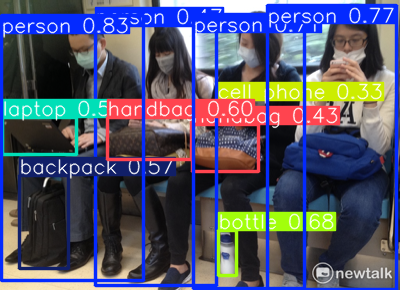

In [27]:
model_yolo = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True)
img, target = dataset[78]

results = model_yolo(f'{images_train_dir}/maksssksksss2.png')

results.print()
results.show()

### Скачаем [репозиторий](https://github.com/ultralytics/yolov5) и запустим файл train.py

In [70]:
!python ../../Skill/5_DL_Detection/yolov5/train.py \
    --data data/mask.yaml \
    --weights yolov5s.pt \
    --imgsz 480 \
    --batch-size 10 \
    --epochs 8 \
    --device cpu \
    --project runs/train \
    --name mask

train: weights=yolov5s.pt, cfg=, data=data/mask.yaml, hyp=../../Skill/5_DL_Detection/yolov5/data/hyps/hyp.scratch-low.yaml, epochs=8, batch_size=10, imgsz=480, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, evolve_population=../../Skill/5_DL_Detection/yolov5/data/hyps, resume_evolve=None, bucket=, cache=None, image_weights=False, device=cpu, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=mask, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest, ndjson_console=False, ndjson_file=False
github: ⚠️ YOLOv5 is out of date by 4 commits. Use 'git pull' or 'git clone https://github.com/ultralytics/yolov5' to update.
YOLOv5 🚀 v7.0-453-geed9bc19 Python-3.13.2 torch-2.7.1 CPU

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_deca

(np.float64(-0.5), np.float64(2399.5), np.float64(1199.5), np.float64(-0.5))

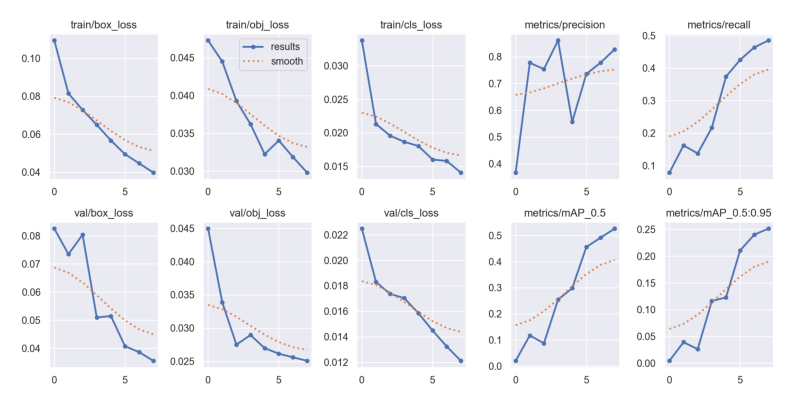

In [ ]:
%matplotlib inline
learn_img = Image.open('./runs/train/mask/results.png')
plt.figure(figsize=(10, 8))
plt.imshow(learn_img)
plt.axis('off')

In [ ]:
results = pd.read_csv('./runs/train/mask/results.csv')

results.columns = results.columns.str.strip()
last_epoch = results[results['epoch'] == 7]


print('train loss:', last_epoch['train/box_loss'].values[0])
print('val loss:', last_epoch['val/box_loss'].values[0])
print('precision:', last_epoch['metrics/precision'].values[0])
print("recall:", last_epoch['metrics/recall'].values[0])
print("mAP@0.5:", last_epoch['metrics/mAP_0.5'].values[0])

train loss: 0.039717
val loss: 0.035518
precision: 0.82755
recall: 0.48506
mAP@0.5: 0.52618


(np.float64(-0.5), np.float64(1919.5), np.float64(1319.5), np.float64(-0.5))

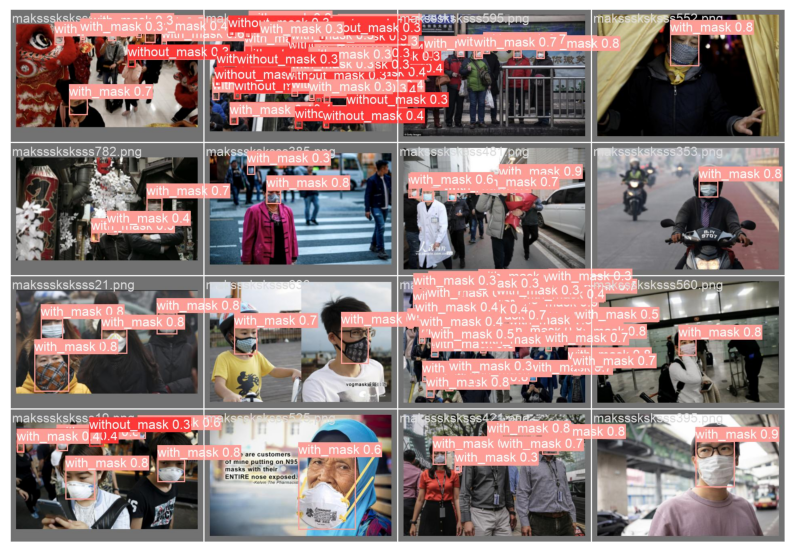

In [71]:
%matplotlib inline
learn_img = Image.open('./runs/train/mask/val_batch2_pred.jpg')
plt.figure(figsize=(10, 8))
plt.imshow(learn_img)
plt.axis('off')

# Итог

В ходе реализации проекта были успешно обучены и протестированы две современные архитектуры для задач обнаружения объектов: YOLO и Faster R-CNN. 

Лучшие показатели точности продемонстрировала модель Faster R-CNN. Она показала более высокую способность к детекции мелких масок на лицах. Следовательно, для задач, где критически важна максимальная точность предпочтительным выбором является Faster R-CNN.

Модель YOLO показала значительное преимущество в скорости обучения. Она достигла удовлетворительного уровня сходимости за заметно меньшее время и с меньшими вычислительными затратами. Это делает YOLO предпочтительной в сценариях, требующих быстрого обучения с ограниченными вычислительными ресурсами.